# **Set up:**
First you need to install R kernel in your Jupyter. If you have no R kernel, you can alternatively go to this link: https://colab.research.google.com/drive/1aMPkM_hx9gxqM4JjV4IRqJofDptpNLW8?usp=sharing
or
Follow the commands in your local R.

**Install packages used**

In [19]:
Sys.setenv(PATH= paste("/conda/bin" , Sys.getenv("PATH"), sep = ":" ) )
install.packages('tidyverse', repos='http://cran.rstudio.com/')
install.packages("epiDisplay", repos = "http://cran.rstudio.com/")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



**Clear working space**

In [7]:
rm(list=ls())

**Import packages to use**

In [20]:
library(tidyverse)
library(epiDisplay)
library(data.table)

Loading required package: foreign

Loading required package: survival

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: nnet


Attaching package: ‘epiDisplay’


The following object is masked from ‘package:ggplot2’:

    alpha



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




**Online data import (Optional)**

In [9]:
temp <- tempfile()
download.file("https://drive.google.com/uc?id=1pAy5L-BHCcAIVg1h4jOaPaWWlfPBYMVO&authuser=0&export=download",
  temp)

**Import data into R**
Note that, if you need to run in your local R, you may use alternative command following hashtag#

In [10]:
ccex<-readRDS(temp)
#ccex<-readRDS("Data_of_sample_frame.rds")

# **Explore data**

**Dictionary**

> STRATA [Matched set of subjects]

> PIDGEN [Individual ID generated]

> SEX [Sex] : Male, Female

> AGE [Age group] : 1-10, 11-20, 21-30, 31-40, 41-50, 51-60, 61-70, 71-80

> STATUS [Groups of the subjects] : Case = TRUE, Control = FALSE

> DIAGCODE [ICD-10 diagnoses]

> DIAGTYPE [Type of ICD-10 diagnosis] : 1 = Principle diagnosis, 2 = Comorbidity, 3 = Complication, 4 = Other, 5 = External cause, 6 = Additional code, 7 = Morphology code

Note that, the data were recorded as a long format, each subject could be diagnosed with many ICD-10 diagnoses. Hence, the PIDGEN may be repeated.

In [11]:
head(ccex)

,STRATA,PIDGEN,SEX,AGE,STATUS,DIAGCODE,DIAGTYPE,P_WEEKS
,<chr>,<chr>,<chr>,<fct>,<lgl>,<chr>,<int>,<int>
1,2070,0001,Male,"(20,30]",TRUE,I828,1,25
2,1961,0002,Female,"(30,40]",FALSE,J181,1,28
3,1264,0003,Male,"(30,40]",FALSE,C384,1,41
4,1264,0003,Male,"(30,40]",FALSE,M8565,5,21
5,1758,0004,Male,"(30,40]",TRUE,D135,1,6
6,2138,2305,Female,"(30,40]",TRUE,J90,1,49


**Check the number of cases and controls (in various case:control ratios):**
One case can be matched to control with flexible criterias: 1:1, 1:2, 1:3, or 1:4 to put them into the sample frame as possible as they can be matched.


> **!!!** If **1:5 or more **>> Only 4 controls would be randomly selected to be matched with the case.





In [12]:
pt<-unique(ccex,by="PIDGEN") %>% mutate(STATUS = ifelse(STATUS==TRUE,"case","control")) %>% group_by(STRATA,STATUS) %>% summarise(number = n())
pt<-as.data.frame(pt)
ptc<-spread(data=pt,key=STATUS,value=number,fill=0)
lrm<-ptc[ptc$case>0&ptc$control>0&!is.na(ptc$case)&!is.na(ptc$control),]
mta<-lrm %>% group_by(case,control) %>% summarise(number = n()) %>% as.data.frame()
mta$cum.case<-mta$case*mta$number
mta$cum.control<-mta$control*mta$number
print(mta)

`summarise()` has grouped output by 'STRATA'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'case'. You can override using the `.groups` argument.


   case control number cum.case cum.control
1     1       1     35       35          35
2     1       2     17       17          34
3     1       3     11       11          33
4     1       4    273      273        1092
5     2       2      1        2           2
6     2       3      1        2           3
7     2       4      1        2           4
8     2       5      2        4          10
9     2       7      2        4          14
10    2       8     41       82         328
11    3       2      1        3           2
12    3       6      1        3           6
13    3      10      1        3          10
14    3      12     12       36         144
15    4      16      5       20          80
16    5      20      2       10          40
17    6      24      4       24          96
18    7      15      1        7          15
19    7      27      1        7          27
20    7      28      2       14          56
21    8      23      1        8          23
22    8      32      2       16 

**Explore age-sex distribution**

In [14]:
ccmat<-unique(ccex[STRATA %in% lrm$STRATA,],by="PIDGEN") %>% mutate(STATUS = ifelse(STATUS==TRUE,"case","control")) %>% group_by(SEX,AGE) %>% 
  summarise(mat=length(unique(STRATA)),total =n(),
            case=sum(STATUS=="case"),control=sum(STATUS=="control")) %>%
  as.data.frame()
print(ccmat)

`summarise()` has grouped output by 'SEX'. You can override using the `.groups` argument.


      SEX     AGE mat total case control
1  Female  (0,10]  26   170   34     136
2  Female (10,20]  13    65   14      51
3  Female (20,30]  23   141   29     112
4  Female (30,40]  26   153   32     121
5  Female (40,50]  12    74   16      58
6  Female (50,60]  11    72   15      57
7  Female (60,70]   8    51   11      40
8  Female (70,80]   9    65   14      51
9    Male  (0,10]  26   149   30     119
10   Male (10,20]  13    80   16      64
11   Male (20,30]  51   368   77     291
12   Male (30,40]  47   355   74     281
13   Male (40,50]  53   326   75     251
14   Male (50,60]  49   286   67     219
15   Male (60,70]  28   184   43     141
16   Male (70,80]  22   162   36     126


# **Analysis**

**Loop computing of crude odd ratios for all ICD-10 diagnoses**

In [21]:
run1<-data.frame(run=1:length(unique(ccex$DIAGCODE)),DIAGCODE=unique(ccex$DIAGCODE))
cror<-data.frame()
for(i in 1:nrow(run1)){
  upd<-NULL
  lcc<-ccex
  lcc$ex<-lcc$DIAGCODE==run1[i,2]
  lcc<-lcc[order(-ex),]
  lcc<-unique(lcc,by="PIDGEN")
  upd$dx<-run1[i,2]
  upd$a<-nrow(lcc[STATUS==TRUE & ex==TRUE,])
  upd$b<-nrow(lcc[STATUS==FALSE & ex==TRUE,])
  upd$c<-nrow(lcc[STATUS==TRUE & ex==FALSE,])
  upd$d<-nrow(lcc[STATUS==FALSE & ex==FALSE,])
  upd$cror<-upd$a*upd$d/(upd$b*upd$c)
  upd<-as.data.frame(upd)
  cror<-rbind(cror,upd)
}

**Select ten common ICD-10 diagnoses preceding TB**

In [22]:
run2<-cbind(run=1:10,cror %>% arrange(-a,-cror) %>% head(10))
print(run2)

   run   dx  a  b   c    d       cror
1    1 J189 33 39 550 2079  3.1984615
2    2 E876 30 99 553 2019  1.1063620
3    3 J159 21 35 562 2083  2.2238434
4    4 E871 20 33 563 2085  2.2444696
5    5  J90 17  9 566 2109  7.0382803
6    6 R042 10  1 573 2117 36.9458988
7    7 J441 10 21 573 2097  1.7427076
8    8 J181  9  6 574 2112  5.5191638
9    9 A099  9 50 574 2068  0.6485017
10  10 R509  8 35 575 2083  0.8280248


**Conditional logistic regression for ten common ICD-10 diagnoses preceding TB**
and also extract preceding duration before detection of TB for all of them.

In [23]:
ror<-data.frame()
for(i in 1:nrow(run2)){
  upd<-NULL
  lcc<-ccex
  lcc$ex<-lcc$DIAGCODE==run2[i,2]
  lcc<-lcc[order(-ex),]
  lcc<-unique(lcc,by="PIDGEN")
  upd$dx<-run2[i,2]
  upd$a<-run2$a[i]
  upd$b<-run2$b[i]
  upd$c<-run2$c[i]
  upd$d<-run2$d[i]
  clogit1 <- clogit(STATUS ~ ex+strata(STRATA),data=lcc) 
  cof<-summary(clogit1)
  upd$or<-round(cof$conf.int[1],3)
  upd$lo95<-round(cof$conf.int[3],3)
  upd$up95<-round(cof$conf.int[4],3)
  upd$pv<-ifelse(round(cof$coefficients[5],4)<0.001,"<0.001",round(cof$coefficients[5],4))
  upd$pdq1<-round(as.numeric(summary(lcc$P_WEEKS[lcc$ex==TRUE])[2]),1)
  upd$pdm<-round(as.numeric(summary(lcc$P_WEEKS[lcc$ex==TRUE])[3]),1)
  upd$pdq3<-round(as.numeric(summary(lcc$P_WEEKS[lcc$ex==TRUE])[5]),1)
  upd<-as.data.frame(upd)
  ror<-rbind(ror,upd)
}

In [24]:
print(ror)

     dx  a  b   c    d     or  lo95    up95     pv pdq1  pdm pdq3
1  J189 33 39 550 2079  3.087 1.914   4.979 <0.001 18.8 31.0 42.2
2  E876 30 99 553 2019  1.042 0.675   1.607 0.8541 17.0 30.0 40.0
3  J159 21 35 562 2083  2.130 1.213   3.737 0.0084 14.0 23.0 33.2
4  E871 20 33 563 2085  2.136 1.180   3.868 0.0122 18.0 25.0 37.0
5   J90 17  9 566 2109  6.149 2.675  14.137 <0.001 21.0 29.5 46.0
6  R042 10  1 573 2117 34.688 4.401 273.388 <0.001 13.0 30.0 35.5
7  J441 10 21 573 2097  1.634 0.752   3.548  0.215 16.5 27.0 39.0
8  J181  9  6 574 2112  6.194 2.045  18.766 0.0013 20.0 24.0 34.5
9  A099  9 50 574 2068  0.631 0.306   1.300 0.2116 20.5 29.0 41.0
10 R509  8 35 575 2083  0.854 0.392   1.858   0.69 15.0 33.0 42.0


# **Check whether the ICD-10 diagnoses were mutually exclusive or not !!!**

In [25]:
case<-ccex[STATUS==TRUE & DIAGCODE %in% ror$dx,]

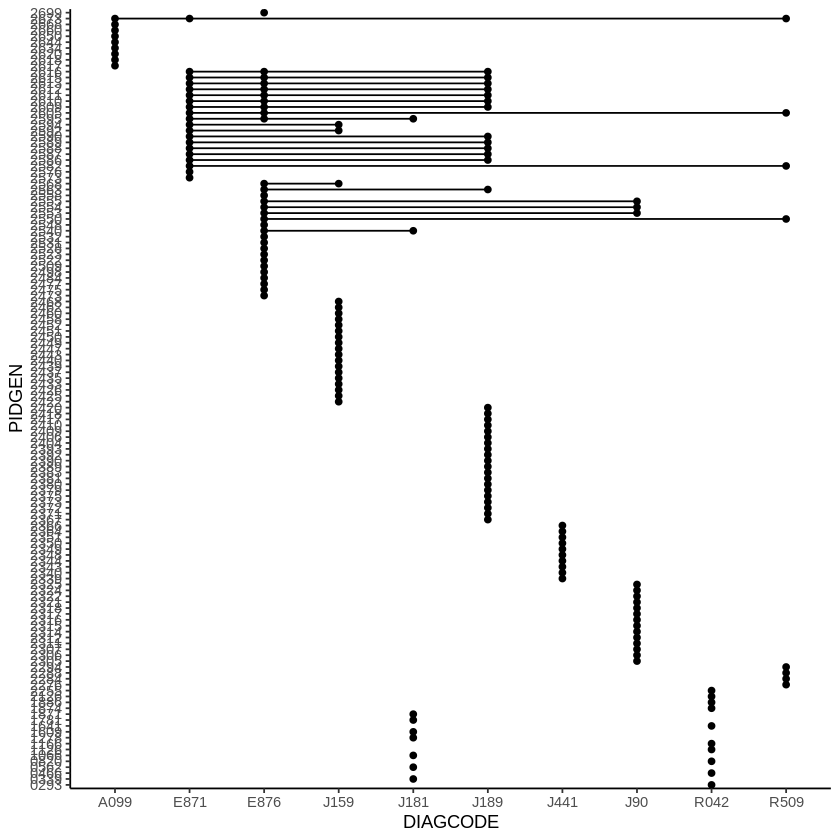

In [26]:
ggplot(case,aes(x=DIAGCODE,y=PIDGEN,group=PIDGEN))+geom_point()+geom_line()+theme_classic()

In [27]:
control<-ccex[STATUS==FALSE& DIAGCODE %in% ror$dx,]

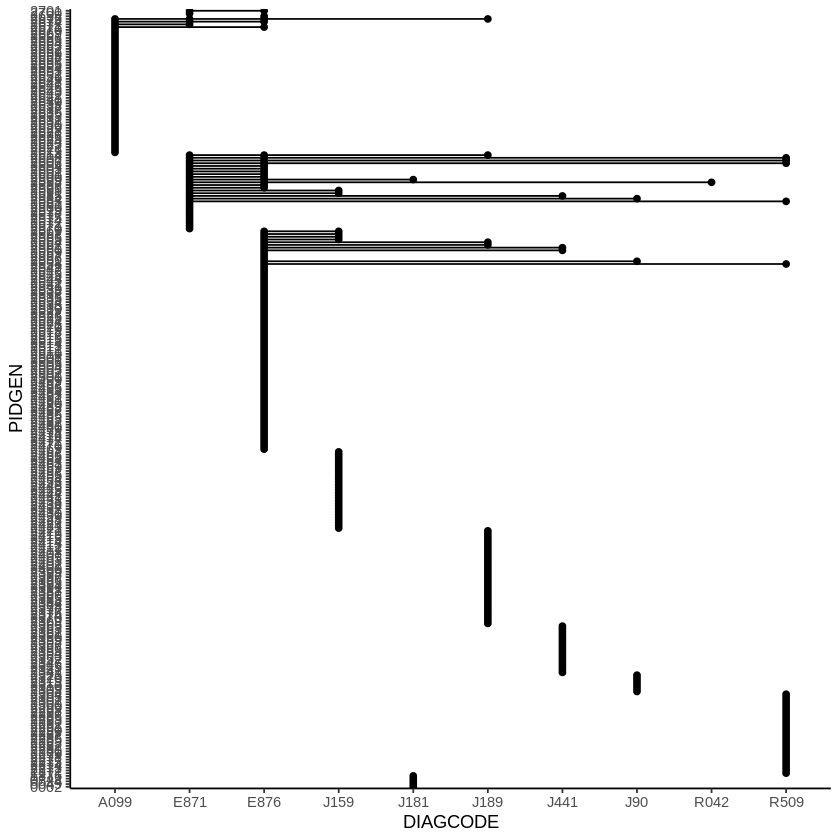

In [28]:
ggplot(control,aes(x=DIAGCODE,y=PIDGEN,group=PIDGEN))+geom_point()+geom_line()+theme_classic()

Among ten common ICD-10 diagnoses preceding TB, E871 and E876 could accompany with others. The rest of them were mutually exclusive.

# **Further exploration**
Due to E871, the significant one accompanying with others, we explored more on its principal diagnosis for each TB patient. 

In [29]:
hpn<-ccex[STATUS == TRUE &  DIAGCODE =="E871",]
p_hpn<-ccex[PIDGEN %in% hpn$PIDGEN & DIAGTYPE == 1,]
sum(duplicated(p_hpn$PIDGEN)) #check whethe someone had multiple pricipal diagnoses or not

[1] 0

Each case has only one principal diagnosis

,Frequency,Percent,Cum. percent
J159,2,10,10
J181,1,5,15
J189,12,60,75
J349,2,10,85
R509,3,15,100
Total,20,100,100


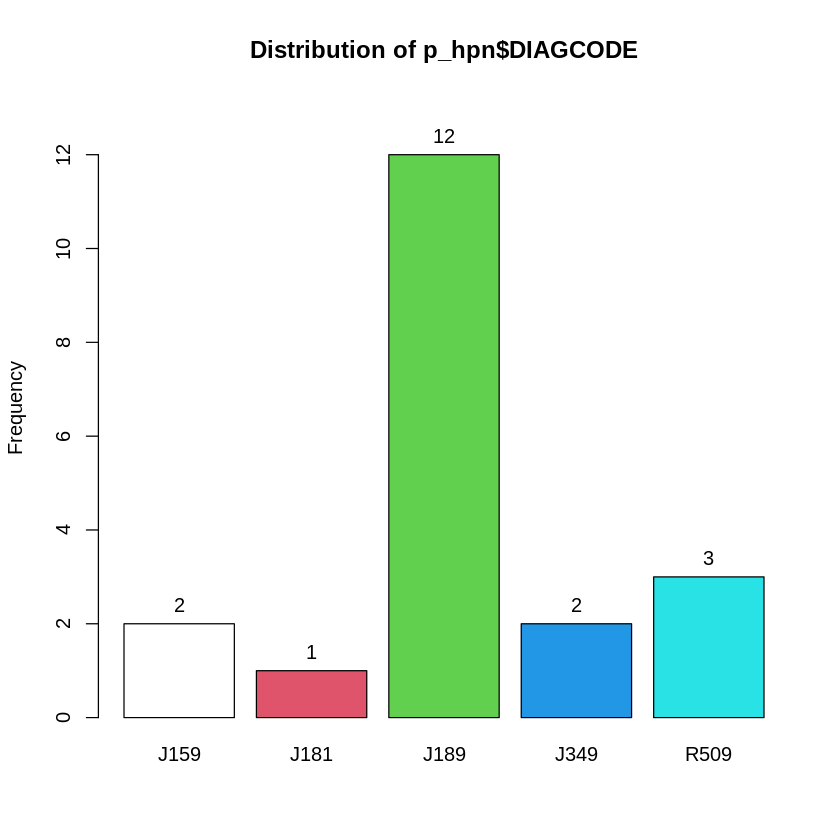

In [30]:
tab1(p_hpn$DIAGCODE)